### In Random Forest 01, 
### we use the features that Scudiero et al. used.

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from itertools import product

import matplotlib.pyplot as plt

### Data

In [3]:
# r'Users/amandaquay/Box\ Sync/90904_FinalProject/SanJoaquinSalinityML/
pathway = 'data_average_after.csv'
df = pd.read_csv(pathway, index_col=0).dropna()
df = df.sort_values(by=['Field_ID']).sort_values(by=['Field_ID'])
# extract independent variables of use
df_small = df[['salinity', 'Field_ID', 'max_CRSI', 'elevation', 'aspect', 
               'slope', 'margins', 'average_temperature', 'total_precipitation']]
df_small.head()

,salinity,Field_ID,max_CRSI,elevation,aspect,slope,margins,average_temperature,total_precipitation
0,0.010,1.0,0.774290,66,328,1,1.0,285.08047,119.0
2,3.827,1.0,0.781937,66,152,0,1.0,285.08047,119.0
3,3.080,1.0,0.775323,66,151,0,1.0,285.08047,119.0
4,1.092,1.0,0.766537,66,149,0,1.0,285.08047,119.0
5,0.146,1.0,0.748702,66,148,0,1.0,285.08047,119.0


In [4]:
df_singlebands = df[['salinity', 'Field_ID', 'max_CRSI', 'elevation', 'aspect', 
                     'slope', 'band_1_mean_2013', 'band_2_mean_2013', 'band_3_mean_2013',
                     'band_4_mean_2013', 'band_5_mean_2013', 'band_7_mean_2013',
                     'average_temperature', 'total_precipitation']]
df_singlebands_or = df_singlebands[df_singlebands.Field_ID != 20.0]

In [5]:
df_outlier_removed = df[df.Field_ID != 20.0]
print(df.size, "-->", df_outlier_removed.size, "samples when field 20 removed")

324005 --> 315755 samples when field 20 removed


In [6]:
df_small_outlier_removed = df_outlier_removed[['salinity', 'Field_ID', 'max_CRSI', 'elevation', 'aspect', 
                                               'slope', 'margins', 'average_temperature', 'total_precipitation']]
df_small_outlier_removed.head()

,salinity,Field_ID,max_CRSI,elevation,aspect,slope,margins,average_temperature,total_precipitation
0,0.010,1.0,0.774290,66,328,1,1.0,285.08047,119.0
2,3.827,1.0,0.781937,66,152,0,1.0,285.08047,119.0
3,3.080,1.0,0.775323,66,151,0,1.0,285.08047,119.0
4,1.092,1.0,0.766537,66,149,0,1.0,285.08047,119.0
5,0.146,1.0,0.748702,66,148,0,1.0,285.08047,119.0


### Functions
###### These functions were mainly pulled from Paul Welle's work

In [7]:
def normalize_X(X_train, X_test):
    x_max = np.max(X_train, axis=0, keepdims=True)
    x_min = np.min(X_train, axis=0, keepdims=True)
    range_x = x_max-x_min
    range_x[range_x==0] = 1
    x_min[range_x==0] = 0
    X_train = (X_train - x_min) / range_x
    X_test = (X_test - x_min) / range_x
    return X_train, X_test

In [8]:
def plot_actual_vs_predicted(actual, predicted, ylim=(0,40), xlim=(0,40)):
    plt.scatter(actual, predicted, s=5, alpha = 0.3)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot((0,40),(0,40), linewidth=2, color='black')
    plt.xlabel('Actual Salinity (dS/m)')
    plt.ylabel('Predicted Salinity (dS/m)')
    plt.show()

In [9]:
def plot_actual_vs_predicted_fields(actual, predicted, field_list, ylim=(0,40), xlim=(0,40)):
    field_dict = { 1.0:[179,0,0],  2.0:[255,51,51],  3.0:[255,153,153],  4.0:[255,133,51],  5.0:[255,179,102],
              6.0:[255,255,26],  7.0:[172,230,0],  8.0:[115,153,0],  9.0:[0,102,34], 10.0:[0,204,102],
             11.0:[0,230,184], 12.0:[102,194,255], 13.0:[0,57,230], 14.0:[153,153,255], 15.0:[255,153,255],
             16.0:[204,0,204], 17.0:[122,0,204], 18.0:[191,128,64], 19.0:[102,51,0], 20.0:[0,0,0],
             21.0:[115,115,115], 22.0:[217,217,217]}
    # normalize this ish
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.xlim((0,40))
    plt.ylim((0,40))
    plt.plot((0,40),(0,40), linewidth=2, color='black')
    plt.xlabel('Actual Salinity (dS/m)')
    plt.ylabel('Predicted Salinity (dS/m)')
    for k, val in field_dict.items():
        for i in range(3): # normalize the RGB values so that matplotlib will allow as input
            field_dict[k][i] = field_dict[k][i]/255.0 
        # find all rows from same field, add to temp lists, and plot them
        temp_y = []
        temp_y_hat = []
        for i in range(len(field_list)): 
            if (k == field_list[i]):
                temp_y.append(actual[i])
                temp_y_hat.append(predicted[i])
        plt.scatter(temp_y, temp_y_hat, s = 5, c = val, label = k) # plot one field at a time to separate labels
    plt.legend(loc = 'upper left', bbox_to_anchor=(1,1), ncol = 2)
    ax.legend(markerscale=4, loc = 'upper left', bbox_to_anchor = (1,1), ncol = 2)
    plt.show()

In [10]:
def train_test_split_lofo(df, drop_columns, test_field=None):
    fields = df['Field_ID'].unique()
    if test_field is None: test_field = np.array([np.random.choice(fields)])
    else: test_field=np.array([test_field])
    train_fields = np.setdiff1d(fields, test_field)

    test_field_indices = np.where(df['Field_ID'].isin(test_field))[0]
    train_field_indices = np.where(df['Field_ID'].isin(train_fields))[0]

    y = df['salinity'].values.reshape(-1,1)
    X = df.drop(df.columns[drop_columns], axis=1).values

    y_train = y[train_field_indices].ravel()
    y_test = y[test_field_indices].ravel()
    X_train = X[train_field_indices]
    X_test = X[test_field_indices]

    return X_train, y_train, X_test, y_test

In [11]:
def cross_validate_lofo(df, drop_columns, train_model_func, reg=0.0, keras=True): 
    y_hat = np.array([])
    fields = df['Field_ID'].unique()
    
    for field in fields:
        X_train, y_train, X_test, y_test = train_test_split_lofo(df, drop_columns, field)
        X_train, X_test = normalize_X(X_train, X_test)
        model = train_model_func(X_train, y_train, X_test, y_test, reg=reg, verbose=0)
        y_hat = np.append(y_hat, model.predict(X_test))
    
    y = df['salinity']
    mse = mean_squared_error(y, y_hat)
    return y_hat, mse

In [12]:
def cross_validate_lofo_sklearn(df, drop_columns, model, normalize=False, **kwargs):
    y_hat = np.array([])
    fields = df['Field_ID'].unique()
    
    for field in fields:
        X_train, y_train, X_test, y_test = train_test_split_lofo(df, drop_columns, field)
        if(normalize): X_train, X_test = normalize_X(X_train, X_test)
        rf = model(**kwargs)
        rf.fit(X_train, y_train)
        y_hat = np.append(y_hat, rf.predict(X_test))
    
    y = df['salinity']
    mse = mean_squared_error(y, y_hat)
    return y_hat, mse

### Random Forest
#### 'Grid Search'

In [16]:
# Define X and y
y = df_small['salinity'].values
drop_columns = [0, 1]
X = df_small.drop(df_small.columns[drop_columns], axis=1).values

In [17]:
# model
model = RandomForestRegressor
parameter_grid = {'n_estimators': [100], 'min_samples_leaf': [1, 2, 10, 20, 50, 100, 200, 300, 400, 500],
                 'max_features': [2, 5, 7]}
kwarg_list = [dict(zip(parameter_grid, v)) for v in product(*parameter_grid.values())]

In [14]:
kwarg_list

[{'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 100},
 {'max_features': 5, 'min_samples_leaf': 1, 'n_estimators': 100},
 {'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 100},
 {'max_features': 2, 'min_samples_leaf': 2, 'n_estimators': 100},
 {'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 100},
 {'max_features': 7, 'min_samples_leaf': 2, 'n_estimators': 100},
 {'max_features': 2, 'min_samples_leaf': 10, 'n_estimators': 100},
 {'max_features': 5, 'min_samples_leaf': 10, 'n_estimators': 100},
 {'max_features': 7, 'min_samples_leaf': 10, 'n_estimators': 100},
 {'max_features': 2, 'min_samples_leaf': 20, 'n_estimators': 100},
 {'max_features': 5, 'min_samples_leaf': 20, 'n_estimators': 100},
 {'max_features': 7, 'min_samples_leaf': 20, 'n_estimators': 100},
 {'max_features': 2, 'min_samples_leaf': 50, 'n_estimators': 100},
 {'max_features': 5, 'min_samples_leaf': 50, 'n_estimators': 100},
 {'max_features': 7, 'min_samples_leaf': 50, 'n_estimators': 100},
 

In [18]:
%%time
mse_list = []
predicted_list = []

for index, kwargs in enumerate(kwarg_list):
    print("Working on:\t" + str(kwargs))
    y_hat, mse = cross_validate_lofo_sklearn(df_small, drop_columns, model,normalize = True, **kwargs) 
    predicted_list.append(y_hat)
    mse_list.append(mse)
    print("\t\tMSE: " + str(mse))

Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 2}
		MSE: 29.256503658182346
Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 5}
		MSE: 27.30464851227259
Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 7}
		MSE: 23.54621938949751
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 2}
		MSE: 28.469532168148735
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 5}
		MSE: 27.752604187096345
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 7}
		MSE: 25.261837162745028
Working on:	{'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 2}
		MSE: 28.092532432296235
Working on:	{'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 5}
		MSE: 25.451342916441995
Working on:	{'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 7}
		MSE: 26.924816074762365
Working on:	{'n_estimators': 100, 'min_samples_leaf': 20, 'max_features': 2}
		MS

In [19]:
best_run_index = np.argmin(mse_list)
params = kwarg_list[best_run_index]
y_hat = predicted_list[best_run_index]
mse = mse_list[best_run_index]

In [20]:
print('best run index:', best_run_index)
print('MAE: %.2f' % mean_absolute_error(y, y_hat))
print('MSE: %.2f' % mean_squared_error(y, y_hat))
print('R_squared: %.2f' % r2_score(y, y_hat))

best run index: 2
MAE: 3.28
MSE: 23.55
R_squared: 0.37


In [21]:
kwarg_list[best_run_index]

{'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 100}

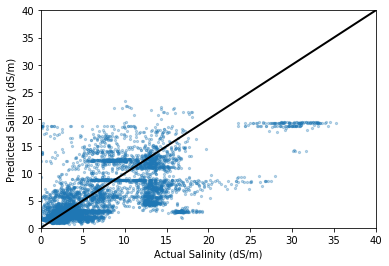

In [22]:
plot_actual_vs_predicted(y, y_hat)

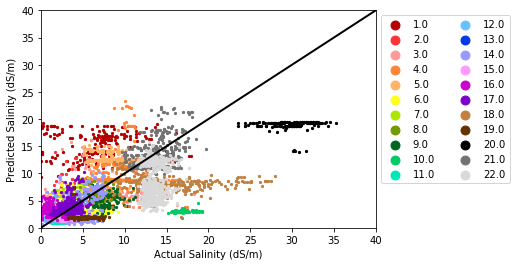

In [23]:
field_list = df_small['Field_ID'].values
plot_actual_vs_predicted_fields(y, y_hat, field_list)

#### Removing Outlier Field (Field #20)

In [24]:
y = df_small_outlier_removed['salinity'].values
drop_columns = [0, 1]
X = df_small_outlier_removed.drop(df_small.columns[drop_columns], axis = 1).values

In [25]:
# model
model = RandomForestRegressor
parameter_grid = {'n_estimators': [100], 'min_samples_leaf': [1, 2, 10, 20, 50, 100, 200, 300, 400, 500],
                 'max_features': [2, 5, 7]}
kwarg_list = [dict(zip(parameter_grid, v)) for v in product(*parameter_grid.values())]

In [26]:
%%time
mse_list = []
predicted_list = []

for index, kwargs in enumerate(kwarg_list):
    print("Working on:\t" + str(kwargs))
    y_hat, mse = cross_validate_lofo_sklearn(df_small_outlier_removed, drop_columns, model,normalize = True, **kwargs) 
    predicted_list.append(y_hat)
    mse_list.append(mse)
    print("\t\tMSE: " + str(mse))

Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 2}
		MSE: 17.90877115892414
Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 5}
		MSE: 19.91108731254138
Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 7}
		MSE: 20.36764989354394
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 2}
		MSE: 18.785785299173344
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 5}
		MSE: 19.544888769216403
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 7}
		MSE: 20.631216874438152
Working on:	{'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 2}
		MSE: 19.430039493783028
Working on:	{'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 5}
		MSE: 19.915789909796686
Working on:	{'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 7}
		MSE: 20.644193950129445
Working on:	{'n_estimators': 100, 'min_samples_leaf': 20, 'max_features': 2}
		MSE

In [27]:
best_run_index = np.argmin(mse_list)
params = kwarg_list[best_run_index]
y_hat = predicted_list[best_run_index]
mse = mse_list[best_run_index]

In [28]:
print('best run index:', best_run_index)
print('MAE: %.2f' % mean_absolute_error(y, y_hat))
print('MSE: %.2f' % mean_squared_error(y, y_hat))
print('R_squared: %.2f' % r2_score(y, y_hat))

best run index: 0
MAE: 3.09
MSE: 17.91
R_squared: 0.29


In [29]:
kwarg_list[best_run_index]

{'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 100}

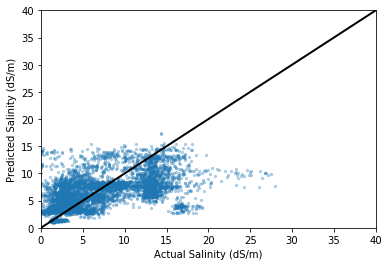

In [30]:
plot_actual_vs_predicted(y, y_hat)

field_dict = { 1:'#B30000',  2:'#FF3333',  3:'#FF9999',  4:'#FF8533',  5:'#FFB366',
              6:'#FFFF1A',  7:'#ACE600',  8:'#739900',  9:'#006622', 10:'#00CC66',
             11:'#00E6B8', 12:'#66C2FF', 13:'#0039E6', 14:'#9999FF', 15:'#FF99FF',
             16:'#CC00CC', 17:'#7A00CC', 18:'#BF8040', 19:'#663300', 20:'#000000',
             21:'#737373', 22:'#D9D9D9'}

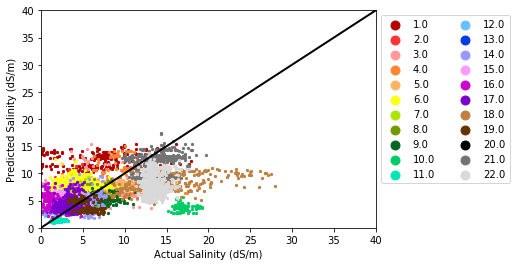

In [31]:
field_list = df_small_outlier_removed['Field_ID'].values
plot_actual_vs_predicted_fields(y, y_hat, field_list)